------

# Data Analysis and Knowledge Discovery: Exercise 2, Supervised learning

The previous exercise was about <i>data understanding</i> and <i>data preparation</i>, which formed the basis for the modeling phase of the data mining process. Many modeling techniques make assumptions about the data, so the exploration and preparation phases can't be ignored. Now, as we have checked the validity of data and familiarized ourselves with it, we can move on to the next stage of the Cross-Industry Standard Process for Data Mining (CRISP-DM), which is <font color = green>modeling</font>.

The questions to be answered at this stage could include:

- What kind of model architecture best fits our data?
- How well does the model perform technically?
- Could we improve its performance?
- How do we evaluate the model's performance?

<i>Machine learning</i> is a subfield of artificial intelligence that provides automatic, objective and data-driven techniques for modeling the data. Its two main branches are <i>supervised learning</i> and <i>unsupervised learning</i>, and in this exercise, we are going to use the former, <font color = green>supervised learning</font>, for classification and regression tasks.

For classification, data remains the same as in the previous exercise, but I've already cleaned it up for you. Some data pre-processing steps are still required to ensure that it's in an appropriate format so that models can learn from it. Even though we are not conducting any major data exploration nor data preparation this time, <i>you should <b>never</b> forget it in your future data analyses</i>.

------

### Gather all packages needed for this notebook here:

You can use other packages as well, but this excercise can be completed with those below.

In [2]:
import numpy as np
import pandas as pd

# Visualization packages - matplotlib and seaborn
# Remember that pandas is also handy and capable when it comes to plotting!
import seaborn as sns
import matplotlib.pyplot as plt

# Machine learning package - scikit-learn
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import Ridge, LinearRegression

# Show the plots inline in the notebook
%matplotlib inline

______________
## <font color = lightcoral>1. Classification using k-nearest neighbors </font> 

We start exploring the world of data modeling by using the <font color = lightcoral>K-Nearest Neightbors (k-NN) algorithm</font>. The k-NN algorithm is one of the classic supervised machine learning algorithms which assumes that similar points are close to each other. 

In our case, we'll use the k-NN algorithm to *predict the presence of cardiovascular disease* (CVD) using all the other variables as <font color = lightcoral>features</font> in the given data set. I.e. the <font color = lightcoral>target variable</font> that we are interested in is `cardio`.

But first, we need data for the task. The code for loading the data into the environment is provided for you. The code should work but make sure that you have the CSV file of the data in the same directory where you have this notebook file.

**Exercise 1 A)**

Take a random sample of 1500 rows from the dataframe using your student id as a seed. Print the first 15 rows to check that everything is ok with the dataframe.

*Note: as mentioned, the data remains the same, but cholesterol has been one-hot-encoded for you already. There's also a new variable, gluc (about glucose levels), which is one-hot-encoded for you. It has similar values as cholesterol originally had [normal, at risk, elevated].*


In [32]:
### Loading code provided
# ------------------------------------------------------
# The data file should be at the same location than the 
# exercise file to make sure the following lines work!
# Otherwise, fix the path.
# ------------------------------------------------------

# Path for the data
data_path = 'ex2_cardio_data.csv'

# Read the CSV file 
cardio_data = pd.read_csv(data_path)

In [58]:
### Code - Resample and print 15 rows

random_samples = cardio_data.copy().sample(n=1500, random_state=525282) #Random sample of 1500 rows from cardio_data with student ID as seed
print(random_samples.head(15)) #Print first 15 rows of cardio_data

      age  gender  height  weight  ap_hi  ap_lo  smoke  alco  active  cardio  \
651    44       1     158    49.0    120     80      0     0       1       0   
5323   47       1     161    85.0    110     70      0     0       0       1   
3729   40       1     170    90.0    115     90      0     0       1       0   
3514   49       2     164    55.0    120     80      0     0       1       0   
2620   58       2     165    65.0    120     70      0     0       1       0   
2006   59       1     151    68.0    110     80      0     0       1       0   
2294   43       1     154    83.0    120     80      0     0       1       0   
5176   53       2     170    67.0     90     60      0     0       0       1   
1038   63       1     153    57.0    120     80      0     1       1       0   
4528   63       1     153    66.0    120     80      0     0       1       1   
963    58       1     175   107.0    120     80      0     0       0       0   
978    59       2     187    80.0     12

----

We have the data so now, let's put it to use. 

To teach the k-NN algorithm (or any other machine learning algorithm) to recognize patterns, we need <font color = lightcoral>training data</font>. However, to assess how well a model has learned these patterns, we require <font color = lightcoral>test data</font> which is new and unseen by the trained model. It's important to note that the test set is not revealed to the model until after the training is complete.

So, to *estimate the performance of a model*, we may use a basic <font color = lightcoral>train-test split</font>. The term "split" is there because we literally split the data into two sets.

**Exercise 1 B)**

Collect the features as an array named `features`, and the target variable as an array named `labels`. Create training and test data by randomly splitting the data into training (80%) and test (20%) sets.

- Do you need stratification for our dataset? Explain your decision.

In [195]:
### Code - Train-test split

features = random_samples.copy()#Assign a random_samples copy to features to avoid changing the original dataset
features.drop(['cardio'], axis=1, inplace=True) #Drop cardio column from features
labels = random_samples.copy()['cardio'] #Assign cardio column to labels

features_train, features_test, labels_train, labels_test = train_test_split( #Split features and labels into training and testing sets
    features,
    labels,
    test_size=0.2, #train_size gets the rest 80% automatically
    stratify=labels,
)


In [184]:
labels.value_counts() #Print value counts of cardio column to evaluate if stratification is needed

cardio
0    1057
1     443
Name: count, dtype: int64

Since the value counts of the target variable cardio is imbalanced (1057 vs 443), it's good to use stratification so that the proportions are not biased towards the majority (0). Therefore stratify=labels is added as a parameter.

----------

**Exercise 1 C)** 

Standardize the numerical features: Note that you should now have two separate features that you've divided all the features into.

- Describe how the k-NN model would make predictions about whether or not a patient has a CVD when the features are not standardized, and explain the reasons behind.


In [210]:
### Code - Standardization

scaler = StandardScaler() #Initialize StandardScaler

#Set numerical and categorical features
num_features= ['age','height','weight','ap_hi','ap_lo']
cat_features = ['ap_hi','ap_lo','smoke','alco','active','cholesterol_normal','cholesterol_elevated','cholesterol_high','gluc_normal','gluc_elevated','gluc_high']

#Replace numerical features with standardized numerical features for training and testing sets and make them DataFrames
features_train_stan = pd.DataFrame(scaler.fit_transform(features_train.copy()[num_features]), columns=[num_features])
features_test_stan = pd.DataFrame(scaler.fit_transform(features_test.copy()[num_features]), columns=[num_features])

#Replace features with standardization to training and testing sets
features_train_stan[cat_features] = features_train[cat_features].values
features_test_stan[cat_features] = features_test[cat_features].values

<font color = lightcoral> Write your answer here:

If the data set isn't standardized the k-NN model would emphasize the features with larger scales or ranges. This is due to the algorithms functionality to make predictions based on the distance of data points and the features have different scaling/ arbitrary points 

-------


**Exercise 1 D)**

Train a k-NN model with $k=3$. Print out the confusion matrix and use it to compute the accuracy, the precision and the recall.
- What does each cell in the confusion matrix represents in the context of our dataset?
- How does the model perform with the different classes? Where do you think the differences come from? Interpret the performance metrics you just computed.
- With our dataset, why should you be a little more cautious when interpreting the accuracy?

In [211]:
### Code - the kNN classifier

k = 3 

knn_model = KNeighborsClassifier(n_neighbors=k)
knn_model.fit(features_train_stan, labels_train) #Fit model with training data
prediction = knn_model.predict(features_test_stan) #Predict labels for features_test

conf_matrix = metrics.confusion_matrix(labels_test, prediction) 
print(conf_matrix)

accuracy = conf_matrix.diagonal().sum() / conf_matrix.sum() # Accuracy is the ratio of total correct instances to total instances = (TP+TN)/ (TP+TN+FP+FN)
precision = conf_matrix[1,1] / (conf_matrix[1,1] + conf_matrix[0,1]) #Precision is the ratio of true positives to true positives and false positives = TP/(TP+FP)
recall = conf_matrix[1,1] / (conf_matrix[1,1] + conf_matrix[1,0]) #Recall is the ratio of true positives to true positives + false negatives = TP/(TP+FN)

print(accuracy, precision, recall) #Print accuracy, precision and recall


[[179  32]
 [ 53  36]]
0.7166666666666667 0.5294117647058824 0.4044943820224719


<font color = lightcoral> Write your answer here:

The cells in the confusion matrix represent from left to right: true positive, true negative, false positive, false negative. Upper row represents how many were predicted correctly and lower how many wrong. In the context of our dataset it had a set of 300 from 1500 to do the predictions and ~85 of them went wrong, therefore the accuracy is tolerable.

As the precision score is about 53% it would suggest that the accuracy of the positive predictions is almost at a coin toss level. This may be caused by the binary/ categorical nature of some of the features, which aren't as measurable as the numeric.

With this dataset already being unbalanced from the start (mixture of different measurable content, categorical and binary features) the metrics provide insight in the actual performance of the model. The high accuracy of the dataset might relate to the model predicting the majority class


---------------

You randomly divided the data into two sets, one for training the k-NN model and the other for evaluating its performance. However, randomness is not the thing we really need, and in fact, it's not something we even desire. Instead, what we do want is to keep track of each step we're making and exporing. This said, the *reproducibility* of the results is extremely important in research. To achieve this, we can utilize <font color = lightcoral> a random seed</font>, with which we can re-run the codes and get the exact same results than before.

For example, we can use a fixed seed when we're shuffling the data before splitting it into training and test sets. This ensures that when we're re-runing the code, we obtain exactly the same partitions of the data in each split.

**Exercise 1 E)**

Initialize 1000 random seeds and continue with the k-NN model ($k=3$): Perform 1000 different train-test splits using these seeds and store the accuracies from each split. Plot the accuracies in a histogram, and discuss your results.

*Tip: You can add the accuracy from the previous exercise in the plot by drawing a vertical line with the function `matplotlib.axes.Axes.axvline(<accuracy>)` if you want!*

In [213]:
### Code - Initialization of the 1000 fixed seeds

random_seeds = np.random.randint(100000, size=1000) #Generate 1000 random seeds between 0 and 100000
splits = []

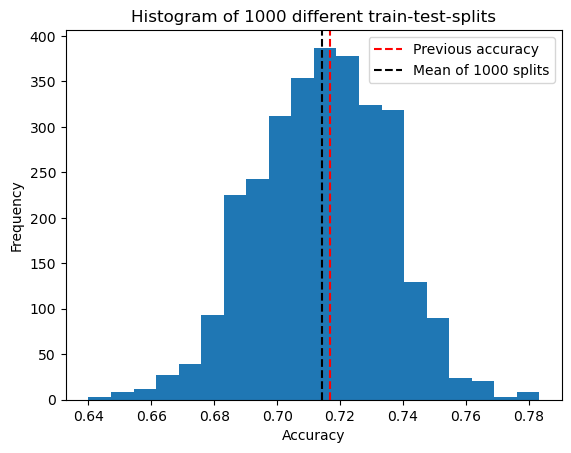

In [216]:
### Code - 1000 different train-test-splits

for seed in range(len(random_seeds)): #Loop to generate 1000 different train-test-splits
    feature_train, feature_test, label_train, label_test = train_test_split(
        features,
        labels,
        test_size=0.2,
        stratify=labels,
        random_state=random_seeds[seed]
    )
    
    loop_knn_model = KNeighborsClassifier(n_neighbors=k, n_jobs=-1) #Initialize KNN model, n_jobs = -1 uses all processors
    loop_knn_model.fit(feature_train, label_train)
    loop_prediction = loop_knn_model.predict(feature_test)
    loop_accuracy = metrics.accuracy_score(label_test, loop_prediction) #Instead of calculating accuracy with confusion matrix, we can use accuracy_score function
    splits.append(loop_accuracy)
    
     #Plot histogram of splits
plt.hist(splits, bins=20)
plt.axvline(x=accuracy, color='red', linestyle='--') #Red line is the previous exercise accuracy
plt.axvline(x=np.mean(splits), color='black', linestyle='--') #Green line is the mean of the 1000 splits
plt.title('Histogram of 1000 different train-test-splits')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.legend(['Previous accuracy', 'Mean of 1000 splits'])


<font color = lightcoral> Write your answer here:


It appears that the accuracy scores vary between 0.65 and 0.75 with the majority in ~0.71 (close to the previously calculated accuracy). The accuracy is spread normalized indicating that the y-axis represents the relative frequency rather than the actual frequency and as the accuracy score variance is small, the performance of the k-nn model is consistent  </font>

------

One really common evaluation metric is <font color = lightcoral>the area under the receiver operating characteristic (AUROC, AUC or AUC-ROC)</font>.  It provides a measure of a model's ability to distinguish between classes, especially in binary classification tasks between the <i>positive class</i> and the <i>negative class</i>. (There sure are multiclass and multilabel cases too, but they are out of scope here.) 

In our case, individuals who have a CVD form the positive class. As the name of the measure suggests, it combines two keys aspects to interpret a model's performance: ROC curves are about the trade-off between the true positive rate and the false positive rate, the former representing the model's ability to correctly identify individuals with a CVD (true positives) and the latter measuring the model's tendency to incorrectly classify individuals without a CVD as if they have the disease (false positives). Thus, the area beneath the curve is simply the AUROC, a single numerical value, that summarizes the overall performance.

**Exercise 1 F)** 

Evaluate the performance of the trained k-NN model by computing the AUROC and plotting the related curve. Draw also the line for random guesses.

- How well does the k-NN model perform in distinguishing between healthy individuals and those with a CVD?


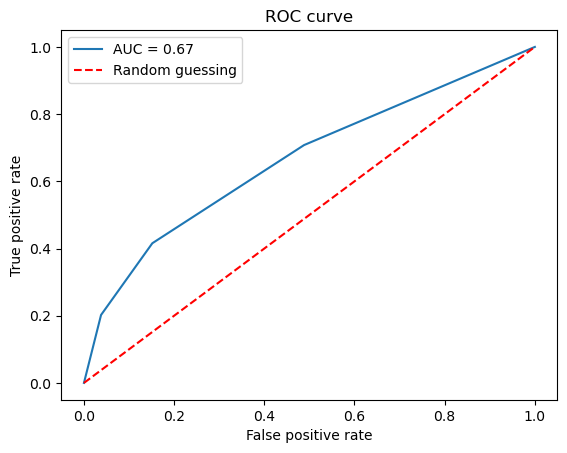

In [219]:
### Code - ROC curve and AUROC

loop_probability = loop_knn_model.predict_proba(feature_test)[:,1] #Calculate probability of positive class (since 2d array, we take the second column for positive class)
fpr, tpr, thresholds = metrics.roc_curve(label_test, loop_probability) #Calculate false positive rate, true positive rate and thresholds for ROC curve
auc = metrics.auc(fpr, tpr) #Calculate area under the curve
plt.plot(fpr, tpr) #Plot ROC curve
plt.plot([0,1], [0,1], color='red', linestyle='--') #Plot diagonal line representing random guessing
plt.title('ROC curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(['AUC = %0.2f' % auc, 'Random guessing']) #Print AUC (two decimal) value and random guessing line on the plot 

<font color = lightcoral> Write your answer here:

As the middle diagonal line divides the space (above: better than random, below: worse than random), the model is better than random, but not reliable. This may be because the model size is too small or due to the imbalanced classes</font>

__________
## <font color = royalblue> 2. Classification accuracy using leave-one-out cross-validation

While the train-test split may provide us with an unbiased estimate of the performance, we only evaluate the model once. Especially when dealing with small datasets, a test set itself will be very small. How can we be sure that the evaluation is accurate with this small test set and not just a good (or bad) luck? And what if we'd like to compare two models and the other seems to be better -- how can we be sure that it's not just a coincidence?

Well, there's a great help available and it's called <font color = royalblue>cross-validation</font>. With its help, we can split the dataset into multiple different training and test sets, which allows us to evaluate models across various data partitions. This time, we'll take a closer look at the <font color = royalblue>leave-one-out cross-validation</font>.

**Exercise 2**

Let's keep the focus on detecting the CVD, so once again we utilize the k-NN model (with $k=3$) to predict the precense of the disease. Now, apply leave-one-out cross-validation to assess whether the k-NN model is suitable for addressing the problem. You may use the entire dataset on this task.

- What can you say about the accuracy compared to the previous task?
- What do you think: Does the k-NN model work for the problem in hand? Explain your answer.

*Tip: This sure can be done manually, but `cross_val_score` is quite a handy function too.*

In [232]:
### Code - Leave-one-out cross-validation

knn_model = KNeighborsClassifier(n_neighbors=k)
loo_cv = LeaveOneOut() #Initialize the leave-one-out cross-validation
print(feature_train)
loo_scores= cross_val_score(knn_model, features, labels, cv=loo_cv, n_jobs=-1) #Calculate scores for each fold
print("Cross validation scores: ", loo_scores)
print("Average accuracy:", loo_scores.mean()) #Print mean of scores


      age  gender  height  weight  ap_hi  ap_lo  smoke  alco  active  \
2260   54       2     170    68.0    120     80      0     0       1   
1707   44       1     157    74.0    120     80      0     0       0   
4708   57       2     169    93.0    150     90      0     1       1   
3798   43       2     170    71.0    120     80      0     0       0   
5971   54       1     159    80.0    150    100      0     0       1   
...   ...     ...     ...     ...    ...    ...    ...   ...     ...   
5756   62       2     181    79.0    130     80      0     0       1   
3661   44       2     176    72.0    120     80      0     0       0   
4935   53       1     148    60.0    140     90      0     0       1   
2637   59       1     167    81.0    140     80      0     0       0   
465    54       1     168    68.0    120     80      0     0       1   

      cholesterol_normal  cholesterol_elevated  cholesterol_high  gluc_normal  \
2260                   1                     0        

<font color = lightcoral> Write your answer here:

The k-NN model seems to work reasonably well but the features may need more fine tuning and balancing for more accurate predictions. The k-NN model works well for capturing local patterns</font>

____________
## <font color = forestgreen> 3. Model selection with leave-one-out cross-validation

So far, we've trained one model at a time and I've given the value of k for you. Accuracy is what it is (no spoilers here), but could we still do a little better? Let's explore that possibility through a process known as <font color=green>hyperparameter tuning</font>. The cross-validation is especially important tool for this task. Note here, that model selection and model evaluation (or assessment) are two different things: We use model selection to estimate the performance of various models to identify the model which is most likely to provide the "best" predictive performance for the task. And when we have found this most suitable model, we *assess* its perfomance and generalisation power on unseen data.

This time, we're going to train multiple models, let's say 30, and our goal is to select the best K-Nearest Neighbors model from this set. Most models come with various hyperparameters that require careful selection, and the k-NN model is no exception. Although we're talking about the number of neighbors here, it's important to note that k-NN also has several other hyperparameters. However, for the sake of simplicity, this time we'll focus solely on fine-tuning the number of nearest neighbors, that is, the value of k. 

Let's focus on the model selection part here for the sake of comprehending the cross-validation itself. We'll get later on the whole pipeline, which also includes model assessment.

**Exercise 3**

Find the optimal k value from a set of $k=1...30$ using leave-one-out cross-validation. Plot the accuracies vs. the k values. Again, you may use the entire dataset.

- Which value of k produces the best accuracy when using leave-one-out cross-validation? Compare the result to the previous model with $k=3$.
- If the number of k is still increased, what is the limit that the accuracy approaches? Why?
- Discuss the impact of choosing a very small or very large number of neighbors on the k-NN model's ability to distinguish between the healthy individuals and the ones with CVD.

In [238]:
### Code - Select best model

k_values = range(1, 31)
k_scores = []

#Loop for each k value and calculation of cross validation score
for k in k_values:
    knn_model = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    score = cross_val_score(knn_model, features, labels, n_jobs=-1, cv=LeaveOneOut(), scoring='accuracy')
    k_scores.append(score.mean())


0.7653333333333333 Index:  29
[0.6966666666666667, 0.7213333333333334, 0.7146666666666667, 0.7346666666666667, 0.7373333333333333, 0.738, 0.74, 0.7473333333333333, 0.746, 0.738, 0.75, 0.7386666666666667, 0.7526666666666667, 0.7486666666666667, 0.756, 0.7533333333333333, 0.7526666666666667, 0.754, 0.758, 0.7533333333333333, 0.7586666666666667, 0.7573333333333333, 0.7566666666666667, 0.7586666666666667, 0.7606666666666667, 0.7546666666666667, 0.764, 0.7613333333333333, 0.7653333333333333, 0.764]


Text(0.5, 1.0, 'Accuracy vs. k-value')

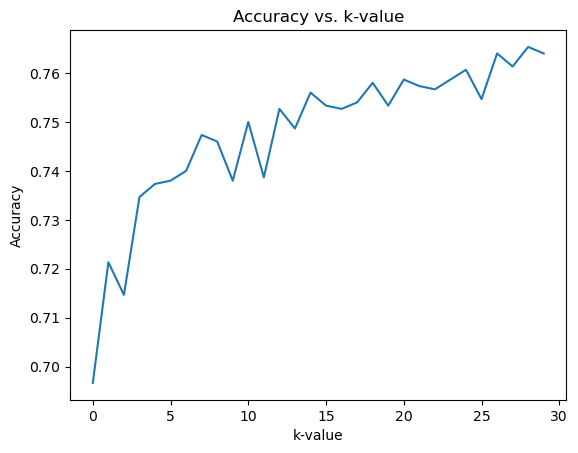

In [244]:
### Code - Plot the accuracies vs. the values for k

print(max(k_scores), "Index: ", (1+k_scores.index(max(k_scores)))) #Print maximum accuracy and it's corresponding k (index)
print(k_scores)
plt.plot(k_scores) #Plot k_score list
plt.xlabel('k-value')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. k-value')

<font color = lightcoral>
Based on the computations, the optimal k value would be 329 (accuracy increases with k-number) but this seems counter-intuitive. A large k-value usually leads to the model becoming biased, due to emphasizing predictions based on overall distribution of the data and missing local structures (underfitting)

This can be caused by the lack of standardization or the evaluation method isn't appropriate to the data. As the precision seems to settle when k increases, it would appear that it would settle around 0.8 overall. If the k-value is low, then usually this leads to overfitting, where the model performs well on the current data but poorly when new data is introduced  </font>

________________
## <font color = red>  4. Training and testing on the same dataset </font>

<i>Note that this should never be done outside of this exercise! You have been warned.</i>

Oh, but what if we just trained a model using the *entire* dataset? Wouldn't we like to use as much data as possible to discover the underlying patterns in the data so why not to use all of it?

**Exercise 4**

This is quite straightforward: Train 30 k-NN models ($k = 1...30$ ) using the whole dataset and evaluate the trained models using, again, the whole dataset. Create a plot that displays the accuracies against the corresponding k values. Include the accuracy values from the previous task in the same figure.

- What's the optimal value for k now and why's that? How would you interpret the reliability of the predictions?
- Explain why you should never use the same dataset for training and testing.

In [251]:
### Code - Train with whole data

from sklearn.metrics import accuracy_score #To simplify the code, we can use accuracy_score function to calculate accuracy

#Copy features and labels to avoid changing the original dataset
full_features = features.copy() #Assign features to full_features to avoid changing the original dataset
full_labels = labels.copy() 
full_accuracies = []

for k in k_values:
    full_model = KNeighborsClassifier(n_neighbors=k)
    full_model.fit(full_features, full_labels) #Fit model with full dataset
    full_pred = full_model.predict(full_features)
    full_accuracy = accuracy_score(full_labels, full_pred)
    full_accuracies.append(full_accuracy)

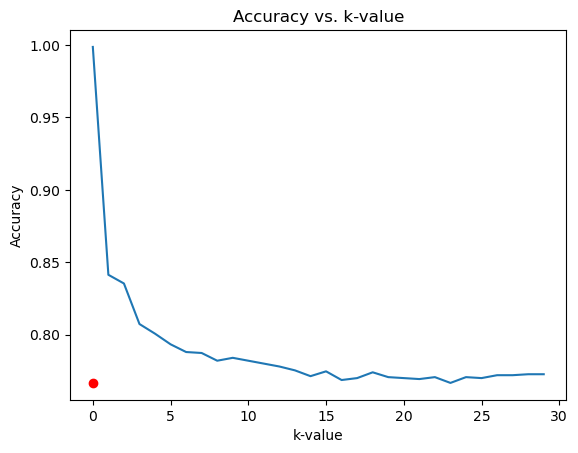

In [258]:
### Code - Plot results

plt.plot(full_accuracies) #Plot k_score list
plt.xlabel('k-value')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. k-value')
plt.scatter(full_accuracies.index(max(full_accuracies)), min(full_accuracies), color='red') #Plot minimum accuracy with red dot



<font color = lightcoral>
Now, the plot indicates that the best value for k would be 0, which cannot be true. It seems that the model makes its predictions based on the nearest single neighbor, thus isn't efficient or usable in situations where new unseen data is introduced.

When training and testing is done on the same dataset, the model becomes overfitted and isn't able to make accurate predictions to new data
</font>

_____________________

## <font color = darkorange> 5. Comparison of ridge regression and k-NN regression </font>

The previous exercises were about classification. Now, we are ready to see another kind of supervised learning - regression - as we are changing our main goal from predicting discrete classes (healty/sick) to estimating continuous values. The following exercises are going to involve utilizing two different regression models, <font color = darkorange>Ridge Regression</font> and <font color = darkorange>K-Nearest Neighbors (k-NN) Regression</font>, and our goal is to evaluate and compare the performances of these two models. 

Let's change the dataset to make the following exercises more intuitive. The new dataset is about brushtail possums and it includes variables such as

- <b>sex</b>: Gender, either male (0) or female (1)
- <b>age</b>: Age in years
- <b>len_head</b>: Head length in cm
- <b>width_skull</b>: Skull width in mm
- <b>len_total</b>: Total length in cm
- <b>len_tail</b>: Tail length in cm
- <b>len_foot</b>: Foot length 
- <b>len_earconch</b>: Ear conch length 
- <b>width_eye</b>: Distance from medial canthus to lateral canthus of right eye, i.e., eye width
- <b>chest</b>: Chest grit in cm
- <b>belly</b>: Belly grit in cm

In this case, our target variable will be *the age of the possum*. The data for this exercise has been modified from the original source.

There's the code chunk for loading data provided again. <font color = red>Again, the data file should be located in the same directory as this notebook file!</font>

In [259]:
### Loading code provided
# ------------------------------------------------------
# The data file should be at the same location than the 
# exercise file to make sure the following lines work!
# Otherwise, fix the path.
# ------------------------------------------------------

# Data path
data_path = 'ex2_possum_data.csv'

# Load the data 
possum_data = pd.read_csv(data_path)

-----------

Regression allows us to examine <font color = darkorange>relationships between two or more variables</font>. This relationship is represented by an *equation*, which itself represents how a change in one variable affects another on average. For example, we could examine how a change in possum's total length affects, on average, its estimated age.

We start by examing those relationships between the variables in the given dataset.


**Exercise 5 A)**

Plot pairwise relationships between the age variable and the others where you color the samples based on the sex variable. 

- Which body dimensions seem to be most correlated with age? And are there any variables that seem to have no correlation with it?
- Are there any differences in the correlations between males and females?

*Tip: `seaborn.pairplot()` is handy with the parameters `(x,y)_vars` and `hue`. You actually can fit a linear model to draw a regression line with the parameter `kind` set to `"reg"`.*

c:\Users\11mul\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


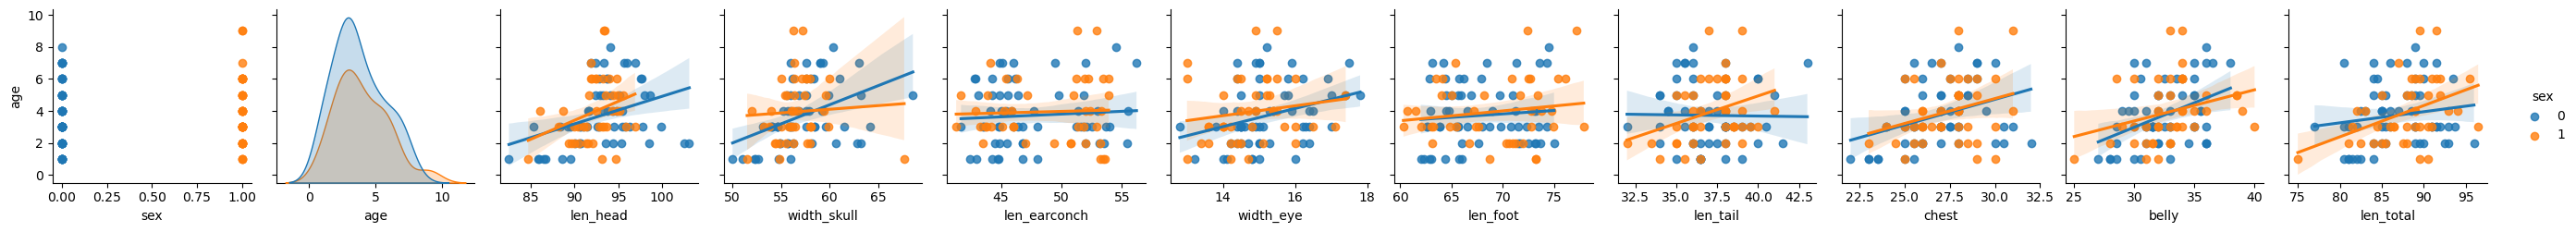

In [260]:
### Code - Pairplot

possum_feature_names = possum_data.columns.tolist() #Get feature names
sns.pairplot(possum_data, x_vars=possum_feature_names, y_vars=['age'], hue='sex', kind='reg') #Plot pairplot of each feature vs. age


<font color = lightcoral> Evaluating from the pairplot, it appears that the greatest aligning slopes are in the chest plot indicating that when chest size increases, age also increases. The more horizontal the line, the less correlation the variables have and in our set the earconch length seems to be the less correlated dimension.

The male (value 1 assumed) and female correlation differences appear in total length, tail length, and skull width. These are represented with crossing lines 

------

Before the regression analysis itself, let's check that our dataset is in a proper format. We'll also perform the train-test split as we're going to first tune the hyperparameters for each model using the training set and test the overall performance of the chosen models using the test set.

**Exercise 5 B)**

Do you need to prepare the data a little? Explain your decision. Perform the train-test (80/20) split. 

In [261]:
### Code - Data preparation

possum_features = possum_data.copy()
possum_features.drop(['age'], axis=1, inplace=True) #Drop age column from features. Sex also since its and binary variable and doesn't need standardization
possum_label = possum_data.copy()['age']
possum_label = possum_label.values.reshape(-1, 1) #Reshape possum_label to 2d array


#Train-test split
possum_features_train, possum_features_test, possum_label_train, possum_label_test = train_test_split(
    possum_features,
    possum_label,
    test_size=0.2,
)
#Standardization
possum_label_train_stan = pd.DataFrame(scaler.fit_transform(possum_label_train), columns=['age'])#Convert to dataframe and rename column to age
possum_label_test_stan = pd.DataFrame(scaler.fit_transform(possum_label_test), columns=['age'])
possum_features_train_stan = pd.DataFrame(scaler.fit_transform(possum_features_train), columns=possum_features.columns.tolist())
possum_features_test_stan = pd.DataFrame(scaler.fit_transform(possum_features_test), columns=possum_features.columns.tolist())

#Add 'sex' feature back to features
possum_features_train_stan['sex'] = possum_data.copy()['sex']
possum_features_test_stan['sex'] = possum_data.copy()['sex']


<font color = lightcoral>
Standardization is needed, since the values are in different ranges. The age and sex features are also dropped from features since age is the target/label variable and sex is binary value which doesn't need standardization the mutations also require to set the train and test sets back to dataframes for easier utilization further on</font>

------

Regarding the k-NN, we have already get familiar with the optimization of the k value. The idea behind the k-NN is the same as previously in classification, the output isn't a class anymore but a continuous value. So, for now, we can stick to the optimal k value. However, for Ridge Regression, we'll focus on the hyperparameter called $\lambda$ (read as 'lambda'), the regularization term (or penalty term or L2 penalty, how ever we'd like to call it), and try to find its optimal value for this task. After the model selection for both regression is performed, we compare the chosen models using a metric called <font color = darkorange>mean absolute error (MAE)</font>.

**Exercise 5 C)**

Train multiple ridge regression models and k-NN regression models. For hyperparameters, use $\lambda=2^{-10}...2^{10}$ and $k=1...30$. Once again, use leave-one-out cross validation. Remember to use only the training dataset for model selection. Plot the optimal k values and lambdas versus corresponding MAEs (two different plots).

- Introduce the optimal hyperparameters for each regression model.
- How do you interpret the MAE in our case when the target variable is age?

*Note: In a `sklearn.linear_model.Ridge` class, lambda is called as "alpha" so don't get confused.*

In [ ]:
### Code - CV for Ridge regression and k-NN regression

possum_k_scores = [] #Initialize list for k-NN scores
possum_ridge_scores = []


lambda_values = 2.0**np.arange(-10,11) #Range of lambda values
def ridge_model(lambda_value, features, labels): #Function to calculate scores for each lambda value
    ridge_model = Ridge(alpha=lambda_value)
    score = cross_val_score(ridge_model, features, labels, n_jobs=-1, cv=LeaveOneOut(), scoring='neg_mean_absolute_error').mean() #scoring='neg_mean_squared_error' is used to get the mean squared error instead of accuracy
    score = abs(score) #For getting a positive score
    return score


def knn_model(k, features, labels): #Function to calculate scores for each k value
    knn_model = KNeighborsRegressor(n_neighbors=k)
    score = cross_val_score(knn_model, features, labels, n_jobs=-1, cv=LeaveOneOut(), scoring='neg_mean_absolute_error').mean() 
    score = abs(score)
    return score

for k in k_values: #Loop to calculate k-NN scores for each k value (k_values previously defined)
    possum_k_score = knn_model(k, possum_features_train_stan, possum_label_train_stan)
    possum_k_scores.append(possum_k_score)

for i in lambda_values: #Loop to calculate ridge scores for each lambda value (lambda_range previously defined)
    possum_ridge_score = ridge_model(i, possum_features_train_stan, possum_label_train_stan)
    possum_ridge_scores.append(possum_ridge_score)


Text(17, 0.8104263555266344, 'min $\\lambda$: 0.810, ($\\lambda$=17)')

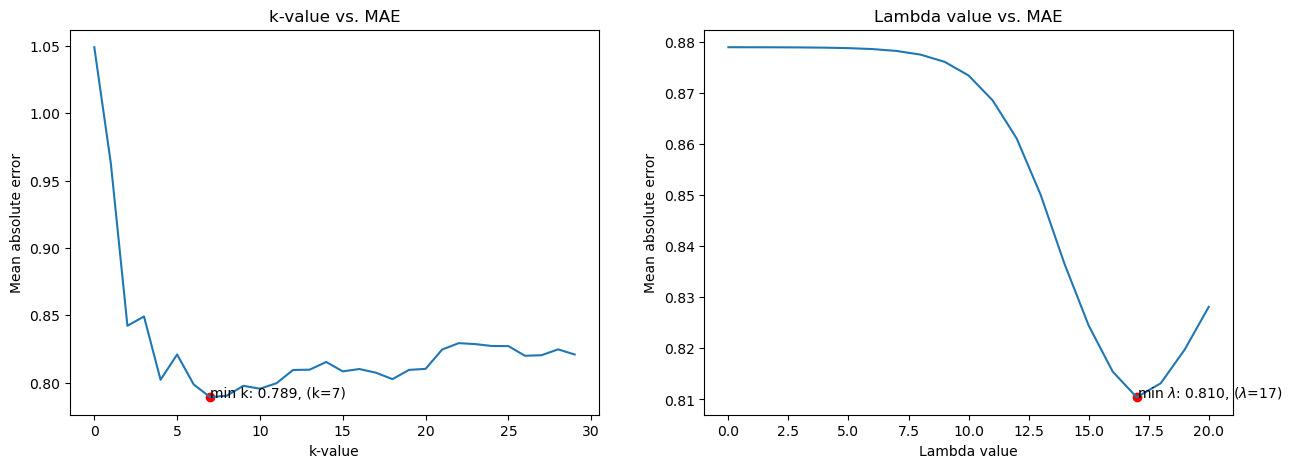

In [ ]:

## Code - Plotting
possum_k_min =min(possum_k_scores) #Get minimum k-NN score
possum_ridge_min = min(possum_ridge_scores) #Get minimum ridge score


plt.figure(figsize=(15,5)) #Plot both scores in the same figure

plt.subplot(1,2,1) #Plot k-NN scores
plt.plot(possum_k_scores)
plt.scatter(possum_k_scores.index(possum_k_min), possum_k_min, color='red') #Plot red dot for minimum k-NN score
plt.title('k-value vs. MAE')
plt.xlabel('k-value')
plt.ylabel('Mean absolute error')
plt.text(possum_k_scores.index(possum_k_min), possum_k_min, f'min k: {possum_k_min:.3f}, (k={possum_k_scores.index(possum_k_min)})') #Add text to the min k position

plt.subplot(1,2,2) #Plot ridge scores
plt.plot(possum_ridge_scores)
plt.scatter(possum_ridge_scores.index(possum_ridge_min), possum_ridge_min, color='red') #Plot red dot for minimum ridge score
plt.title('Lambda value vs. MAE')
plt.xlabel('Lambda value')
plt.ylabel('Mean absolute error')
plt.text(possum_ridge_scores.index(possum_ridge_min), possum_ridge_min, f'min $\lambda$: {possum_ridge_min:.3f}, ($\lambda$={possum_ridge_scores.index(possum_ridge_min)})')


<font color = lightcoral>
The MAE is in the same unit as the target variable. But since the data is standardized the value needs to be recalculated to correspond the actual age variable.A low MAE score indicates that the model is accurate against the true data. In our case the plot shows that the prediction is off by 0.789  when k=7 and 0.81 years when lambda is 17 and while the min standardized value is -1.4941 and max 2.813 (vs(1-9)), this would approximate to 4 years (the min and max computed with possum_label.....max() and min())
</font>

------

The cross-validation was employed for model selection and at this point, we have the optimal hyperparameter settings for each model. Let's finally assess both models using the test set. To continue from this, we first fit the chosen models using the entire training, ensuring that the models are trained with the maximum available data. 

**Exercise 5 D)**

Fit the chosen models with the whole training set. Evaluate the models using the test set and describe the results.

- How well did the models perform in estimating the possums' ages?
- So, what's the pitfall in here if you had compared the overall performance of the models based on the cross-validation MAEs and not the MAEs for the test set?

MAE for k-NN (k=7): 0.622
MAE for Ridge (lambda=17): 0.671


Text(0.5, 1.0, 'Real results vs. predictions')

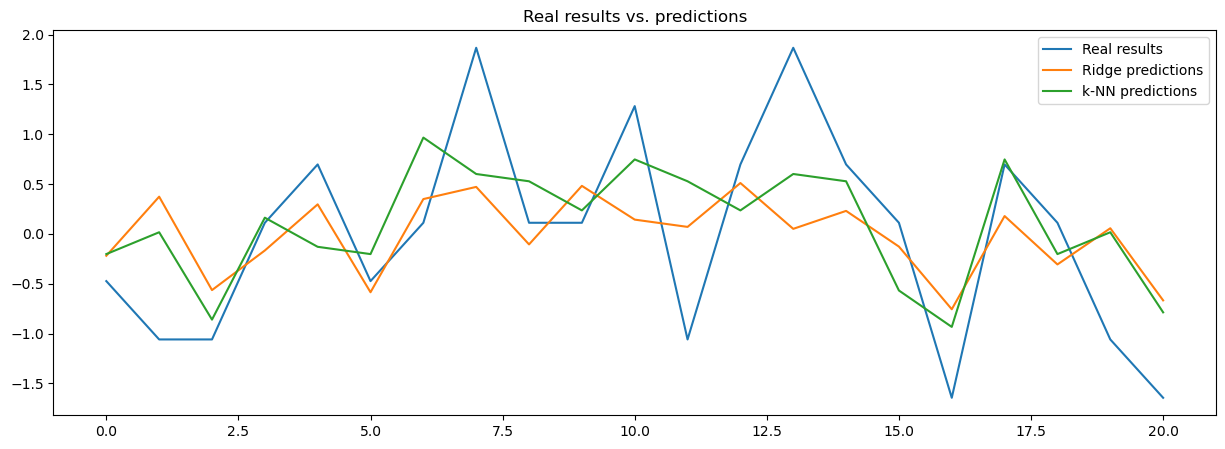

In [ ]:

## Code - Evaluating the selected models

#k-NN training with k=5
knn_model = KNeighborsRegressor(n_neighbors=7)
knn_model.fit(possum_features_train_stan, possum_label_train_stan)
knn_prediction = knn_model.predict(possum_features_test_stan)
knn_mae = metrics.mean_absolute_error(possum_label_test_stan, knn_prediction)

#Ridge training with lambda=17
ridge_model = Ridge(alpha=17)
ridge_model.fit(possum_features_train_stan, possum_label_train_stan)
ridge_prediction = ridge_model.predict(possum_features_test_stan)
ridge_mae = metrics.mean_absolute_error(possum_label_test_stan, ridge_prediction)

print(f"MAE for k-NN (k=7): {knn_mae:.3f}")
print(f"MAE for Ridge (lambda=17): {ridge_mae:.3f}")

plt.figure(figsize=(15,5)) #Plot both predictions in the same figure
plt.plot(possum_label_test_stan, label='Real results')
plt.plot(ridge_prediction, label='Ridge predictions')
plt.plot(knn_prediction, label='k-NN predictions')
plt.legend(loc='best')
plt.title('Real results vs. predictions')


<font color = lightcoral>
While the k-NN model had an overall low score for MAE indicating that it's performing well, the graph indicates that the results maintained in the middle of the actual data. The k-NN model was more efficient overall and the Ridge regression model was less aligned with the increases and decreases of the values

The cross-validation processes aided in getting a more 'clean' estimate on unseen data. As the actual MAE score was lower than the one provided by the cross-validation MAE, it has a more critical approach
></font>